In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

import scipy.io as sio
slim = tf.contrib.slim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')

In [2]:
from nets import txtbox_300, textbox_common, np_methods
from processing import txt_preprocessing
from processing import visualization

In [3]:
isess = tf.InteractiveSession()

In [90]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = txt_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=txt_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'net' in locals() else None
net = txtbox_300.TextboxNet()
with slim.arg_scope(net.arg_scope(data_format=data_format)):
    localisations, predictions,  _ = net.net(image_4d, is_training=False, reuse=True)
    for i in range(len(rpredictions)):
        predictions[i] = tf.nn.softmax(predictions[i])
        


In [86]:
# Restore SSD model.
ckpt_filename = '../checkpoints/model.ckpt-1337.meta'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
#saver = tf.train.import_meta_graph(ckpt_filename)
saver.restore(isess, '../checkpoints/model.ckpt-1469')

# SSD default anchor boxes.
anchors = net.anchors(net_shape)

In [87]:
#rpredictions.shape
loss = isess.run(tf.nn.softmax(tf.constant([[0.52,0.4768492 ],[2.0,5.0]])))
logit_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = tf.constant([[0.52,0.47],[2.0,5.0]]),
                                                         labels =tf.constant([0,1]) )
print isess.run(logit_loss)
print isess.run(tf.reduce_mean(logit_loss))

[ 0.66845965  0.04858733]
0.358523


In [120]:
pmask = tf.constant([0,1,0,0,1])
nmask = 1 - tf.constant([0,1,0,0,1])
loss_neg = tf.where(tf.cast(pmask,tf.bool),
                       tf.cast(tf.zeros_like(pmask),tf.float32),
                       tf.constant([0.2,0.3,0.5,0.6,0.7]))
val,idxes = tf.nn.top_k(loss_neg, k=2)
minval = val[-1]
nmask = tf.logical_and(tf.cast(nmask,tf.bool), loss_neg > minval)
mask = tf.logical_or(nmask,tf.cast(pmask,tf.bool))

In [121]:
isess.run(mask)

array([False,  True, False,  True,  True], dtype=bool)

In [91]:
rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            select_threshold=0.5, img_shape=(300,300), num_classes=2, decode=True)

In [96]:
for i in range(6):
    print np.where(rpredictions[i][:,:,:,:,:,1:] >0.5)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([0]), array([0]), array([1]), array([1]), array([2]), array([0]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2]), array([0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 1,
       1, 1, 2, 2]), array([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0]), array([0, 0, 3, 0, 3, 1, 0, 3, 1, 4, 0, 0, 3, 0, 3, 1, 0, 3, 0, 0, 3, 4, 0,
       3, 1, 0, 3]), array(

In [97]:

# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    

    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=2, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbboxes)
    #rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=1000)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    #rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

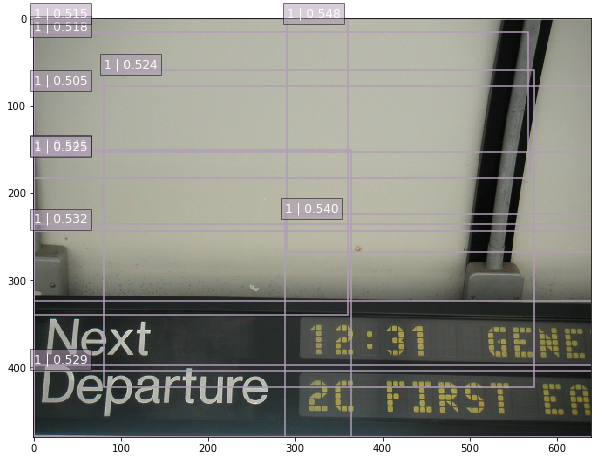

In [98]:
img = mpimg.imread('../data/ICDAR2013/ICDAR-Test-Images/img_120.jpg')
rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)